# 1D linearized shallow-water equation with wind stress


In [ ]:
cd(@__DIR__)

using Pkg; Pkg.activate(".")
# Pkg.resolve(); Pkg.instantiate(); Pkg.precompile()  # Uncomment if needed for reproducibility
using OrdinaryDiffEq, ComponentArrays, Plots, JLD2, Flux, Random, Statistics, ProgressMeter, StatsBase, ParameterSchedulers, BSON, Optimisers, Optim, Zygote, Printf, Dates, StatsPlots
using ParameterSchedulers: Stateful
using Flux: Adam

In [ ]:
const SEED = rand(UInt) 
#const SEED = 6007236083150485430    
Random.seed!(SEED); println("Using seed = $SEED")
output_dir="configuration_experiments"

# surrogate data 
new = false             # upload from data (false) or from surrogates (true)
surrogate = 1           # 1 to 5

K_increase = false   # increase unrolling steps during training
K_global = 2         # unrolling steps in training 
scale_min = 0.4f0    # scale lower bound
scale_max = 1.8f0    # scale upper bound

# init data 
wind_name = "periodic"            # periodic only (other unstable)
correction_init_state = "flat"    # flat or bump or small_bump
longer = false                    # true for longer simulation time 

# surrogate config
predict_increment = true   # false to predict absolute
use_multi_data = true      # several wind amplitudes training 
use_multi_init = false     # if surrogate is created from multi init but this is overwritten later 

# training 
learning_rate = 1e-5 # 1e-3 # 1e-4 # 5e-4
lr_scheduler = Stateful(Exp(learning_rate, 0.99))
n_epochs_corr = 5000 # 10000
batch_size = 32

n_hidden_corr = 128 # 32 # 64 # 20 # 128 # 256
activation_corr = swish # relu # swish # tanh # sigmoid

@show surrogate, new, wind_name, correction_init_state, longer, predict_increment, use_multi_data
nothing 

## Everything

#### set up

In [ ]:
const DEBUG = true
const use_gpu = false

function debug(msg, override::Bool=DEBUG)
    if override
        println(msg)
    end
end

to_device(x) = x
if use_gpu
    try
        using CUDA
        println("CUDA is available. Using GPU.")
        CUDA.seed!(SEED)
        to_device(x) = gpu(x)
    catch e
        println("CUDA.jl not found or error loading it. Using CPU. Error: $e")
    end
else
    println("Using CPU.")
end

In [ ]:
#include("model_1d_viscosity.jl")
include("model_1d_surge_wave.jl")
include("wind_forcing_functions.jl") 
include("normalization-utils.jl")

In [ ]:
# Plot losses for training and validation
colors = palette(:bluegreenyellow)[1:6]
cur_colors = theme_palette(:auto)

In [ ]:
# utils
function constant_func(t, value=0.0)
    return value
end

function run_model_and_extract(f::Wave1DSurge_cpu, x0, times, station_idxs)
    prob = ODEProblem(f, x0, (times[1], times[end]))
    sol = solve(prob, Rodas5(), saveat = times, isoutofdomain = (u, p, t) -> any([u.h[i] + D[i] < 0 for i in 1:length(u.h)]), reltol = 1e-8, abstol = 1e-10)

    n_time = length(times)
    n_stat = length(station_idxs)
    H = zeros(n_time, n_stat)
    U = zeros(n_time, n_stat)

    for (i, t) in enumerate(times)
        state = sol(t)
        H[i, :] = state.h[station_idxs]
        U[i, :] = state.u[station_idxs]
    end

    return sol, H, U
end

# Wind stress forcing as a function of time
function make_tau(amplitude=1.0, period=8*3600.0)
    return t -> (amplitude * sin(2π * t / period))^2
end

q_left(t) = constant_func(t, 0.0)
q_right(t) = constant_func(t, 0.0)


#### params, numerical simulation and surrogate model data

In [ ]:
# import surrogate model data 
if new 
    @load "surrogates/$(correction_init_state)_surrogate$(surrogate)_$(wind_name)_longer$(longer)" surrogate_model H_surrogate U_surrogate surrogate_data
else   
    if longer 
        @load "data/multidata_$(correction_init_state)_$(wind_name)_surrogate_$(surrogate)-longer.jld2" surrogate_model H_surrogate surrogate_data
    else 
        @load "data/multidata_$(correction_init_state)_$(wind_name)_surrogate_$(surrogate).jld2" surrogate_model H_surrogate surrogate_data
    end 
end 

for (k, v) in surrogate_data
    eval(:($(Symbol(k)) = $v))
end

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

In [ ]:
# import wind forcing 
if wind_name == "AR(2)"
    tau_nominal = make_tau_ar(amplitude=amplitude, coeffs=coeffs, sigma=sigma, seed=wind_seed)
    tau_true = make_tau_ar(amplitude=(amplitude * bias_factor), coeffs=coeffs, sigma=sigma, seed=wind_seed)

elseif wind_name == "piecewise"
    tau_nominal = make_tau_piecewise(amplitude=amplitude, avg_duration=avg_duration, noise_level=noise_level, seed=wind_seed) 
    tau_true = make_tau_piecewise(amplitude=(amplitude * bias_factor), avg_duration=avg_duration, noise_level=0.3, seed=wind_seed)

elseif wind_name == "zero"
    tau_nominal = make_tau_zero() # amplitude, period
    tau_true = make_tau_zero() # amplitude * bias_factor, period  

elseif wind_name == "constant"
    tau_nominal = make_tau_constant(amplitude=amplitude)
    tau_true = make_tau_constant(amplitude=(amplitude * bias_factor))

elseif wind_name == "periodic"
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)

elseif wind_name == "multi-frequency" 
    tau_nominal = make_tau_multifreq(amplitude=amplitude, periods=periods, weights=weights, seed=wind_seed)
    tau_true = make_tau_multifreq(amplitude=(amplitude * bias_factor), periods=periods, weights=weights, seed=wind_seed)
else 
    wind_name == "periodic"
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)
end

# both wind functions compared
p = compare_forcings(Dict("Nominal" => tau_nominal,"True, Bias $bias_factor" => tau_true), times)
display(p)
nothing

In [ ]:
function rollout_surrogate(surrogate_model, h0, u0, times, tau_func, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations, amplitude_scale; n_init_conditions=n_init_conditions)
    # Initialize arrays
    h_pred = zeros(length(times), length(h0))
    u_pred = zeros(length(times), length(u0))
    
    h_pred[1,:] = h0
    u_pred[1,:] = u0

    # Convert to vectors
    mu_X = Float32.(vec(mu_X))
    sigma_X = Float32.(vec(sigma_X))
    mu_Y = Float32.(vec(mu_Y))
    sigma_Y = Float32.(vec(sigma_Y))

    # Prepare IC encoding if using multi-IC surrogate
    ic_vec = nothing
    if use_multi_init
        ic_idx = ic_to_idx[correction_init_state]
        ic_vec = zeros(Float32, n_init_conditions)
        ic_vec[ic_idx] = 1.0f0
    end

    for k in 1:(length(times) - 1)
        # Build input vector
        input_vec = Float32[]
        tau_val = Float32(tau_func(times[k]))
        
        # Local features per station
        for i in 1:n_stations
            append!(input_vec, [h_pred[k, i], u_pred[k, i], D_stations[i], mask[i], tau_val, amplitude_scale])
        end

        # Append IC encoding if needed
        if ic_vec !== nothing
            append!(input_vec, ic_vec)
        end
        
        # Normalize
        input_norm = copy(input_vec)
        input_norm[norm_cols_X] = (input_vec[norm_cols_X] .- mu_X) ./ sigma_X
        input_norm[mask_cols_X] = input_vec[mask_cols_X]
        
        input_col = reshape(Float32.(input_norm), :, 1)

        # Predict
        pred_norm = surrogate_model(input_col)
        pred_vec = vec(Array(pred_norm))
        
        # Denormalize
        pred_unnorm = copy(pred_vec)
        pred_unnorm[norm_cols_Y] = pred_vec[norm_cols_Y] .* sigma_Y .+ mu_Y

        # Update state
        if predict_increment
            h_pred[k + 1, :] = h_pred[k, :] .+ pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = u_pred[k, :] .+ pred_unnorm[(n_stations+1):end]
        else
            h_pred[k + 1, :] = pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = pred_unnorm[(n_stations+1):end]
        end
    end

    return h_pred, u_pred  
end

### experiment setup

In [ ]:
if longer 
    @load "data/$(correction_init_state)_$(wind_name)_longer_parameters.jld2" params
else 
    @load "data/$(correction_init_state)_$(wind_name)_parameters.jld2" params 
end 

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

# generate 'truth'
println("\nGenerating TRUE data (with scale=$bias_factor)...")
f_true = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_true, q_left, q_right)
sol_true, H_true, U_true = run_model_and_extract(f_true, x0, times, station_idxs)

# generate nominal data
println("\nGenerating surrogate data (with no scale)...")
f_nominal = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_nominal, q_left, q_right)
sol_nominal, H_nominal, U_nominal = run_model_and_extract(f_nominal, x0, times, station_idxs)

H_nominal = Float32.(H_nominal)
U_nominal = Float32.(U_nominal)
H_true = Float32.(H_true)  
U_true = Float32.(U_true)
times = Float32.(times)

# Ensure all normalization statistics are Float32
mu_X = Float32.(mu_X)
sigma_X = Float32.(sigma_X)
mu_Y = Float32.(mu_Y)
sigma_Y = Float32.(sigma_Y)

D_stations = Float32.(D_stations)
mask = Float32.(mask)

nothing

In [ ]:
# Original surrogate (no correction)
if use_multi_init
    H_surrogate, U_surrogate = rollout_surrogate(surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, mu_X, sigma_X, mu_Y, sigma_Y,
                                                D_stations, mask, n_stations, 1.0f0)
else
    H_surrogate, U_surrogate = rollout_surrogate(surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, mu_X, sigma_X, mu_Y, sigma_Y,
                                                D_stations, mask, n_stations, 1.0f0, n_init_conditions=nothing)
end 

# Prepare the station indices
stations = [station_idxs[1], station_idxs[end ÷ 2], station_idxs[end]]
ylims = [(-1.2, 1.0), (-0.03, 0.04), (-0.8, 1.4)]
titles = ["First Station - Height", "Middle Station - Height", "Last Station - Height"]

# Create the 3-panel layout
plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=ylims[i])
    plot!(plt[i], times ./ 3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, H_surrogate[:, s], label="surrogate", color=cur_colors[end])    
    xlabel!(plt[i], "time (hr)"); ylabel!(plt[i], "h (m)"); title!(plt[i], titles[i])
end

display(plt)
nothing

In [ ]:
function build_correction_normalization_cols(complete_input, n_stations, N_LOCAL_FEATURES, use_multi_init; n_init_conditions=nothing)
    norm_cols_corr = Int[]
    mask_cols_corr = Int[]
    
    if complete_input
        # Local features per station
        for i in 1:n_stations
            offset = (i - 1) * N_LOCAL_FEATURES
            append!(norm_cols_corr, [offset + 1, offset + 2, offset + 3, offset + 5])  # h, u, D, tau
            append!(mask_cols_corr, [offset + 4, offset + 6])  # mask, scale
        end
        
        # CRITICAL FIX: Add IC encoding columns to mask_cols_corr
        if use_multi_init
            ic_start = N_LOCAL_FEATURES * n_stations + 1
            ic_cols = collect(ic_start:(ic_start + n_init_conditions - 1))
            append!(mask_cols_corr, ic_cols)
            println("✓ Added IC encoding columns to mask_cols_corr: ", ic_cols)
        end
        
        return norm_cols_corr, mask_cols_corr
    else
        # Reduced case...
        for i in 1:n_stations
            offset = (i - 1) * 4
            append!(norm_cols_corr, [offset + 1, offset + 2, offset + 3])
            append!(mask_cols_corr, [offset + 4])
        end
        return norm_cols_corr, mask_cols_corr
    end
end


# Compute these once 
if use_multi_init
    norm_cols_corr, mask_cols_corr = build_correction_normalization_cols(true, n_stations, N_LOCAL_FEATURES, use_multi_init, n_init_conditions=n_init_conditions)
else 
    norm_cols_corr, mask_cols_corr = build_correction_normalization_cols(true, n_stations, N_LOCAL_FEATURES, use_multi_init)
end

nothing

In [ ]:
# For input normalization
norm_map_X = Dict{Int, Int}()
for (stat_idx, col_idx) in enumerate(norm_cols_X)
    norm_map_X[col_idx] = stat_idx
end

# For output normalization  
norm_map_Y = Dict{Int, Int}()
for (stat_idx, col_idx) in enumerate(norm_cols_Y)
    norm_map_Y[col_idx] = stat_idx
end

# For correction input normalization
norm_map_corr = Dict{Int, Int}()
for (stat_idx, col_idx) in enumerate(norm_cols_corr)
    norm_map_corr[col_idx] = stat_idx
end

### Correction Network, parametric correction $g(u; \theta) = \theta u$

In [ ]:
configs = []

# Configuration 1: Baseline 
push!(configs, Dict(
    "name" => "baseline", "global_scale" => false, "complete_input" => true, "predict_scale_increment" => true,
    "predict_increment" => predict_increment, "use_multi_data" => use_multi_data, "use_multi_init" => use_multi_init
))

# Configuration 2: Global scale (single α for all stations)
push!(configs, Dict(
    "name" => "global_scale", "global_scale" => true, "complete_input" => true, "predict_scale_increment" => true,
    "predict_increment" => predict_increment, "use_multi_data" => use_multi_data, "use_multi_init" => use_multi_init
))

# Configuration 3: Reduced input features
push!(configs, Dict(
    "name" => "reduced_input", "global_scale" => false, "complete_input" => false, "predict_scale_increment" => true,
    "predict_increment" => predict_increment, "use_multi_data" => use_multi_data, "use_multi_init" => use_multi_init
))

# Configuration 4: Predict absolute scale 
push!(configs, Dict(
    "name" => "absolute_scale", "global_scale" => false, "complete_input" => true, "predict_scale_increment" => false,
    "predict_increment" => predict_increment, "use_multi_data" => use_multi_data, "use_multi_init" => use_multi_init
))

# Configuration 5: Global + Absolute (both)
push!(configs, Dict(
    "name" => "global_absolute_both", "global_scale" => true, "complete_input" => true, "predict_scale_increment" => false,
    "predict_increment" => predict_increment, "use_multi_data" => use_multi_data, "use_multi_init" => use_multi_init
))

# Configuration 6: Minimal features
push!(configs, Dict(
    "name" => "minimal_global", "global_scale" => true, "complete_input" => false, "predict_scale_increment" => false,
    "predict_increment" => predict_increment, "use_multi_data" => use_multi_data, "use_multi_init" => use_multi_init
))

# Configuration 7: Minimal features
push!(configs, Dict(
    "name" => "minimal_perstation", "global_scale" => false, "complete_input" => false, "predict_scale_increment" => false,
    "predict_increment" => predict_increment, "use_multi_data" => use_multi_data, "use_multi_init" => use_multi_init
))

all_data_params = Dict(
    # Models
    "surrogate_model" => surrogate_model,
    
    # Data
    "H_nominal" => H_nominal,
    "U_nominal" => U_nominal,
    "H_true" => H_true,
    "U_true" => U_true,
    "H_surrogate" => H_surrogate,
    "U_surrogate" => U_surrogate,
    "times" => times,
    
    # Wind forcing
    "tau_nominal" => tau_nominal,
    
    # Normalization
    "mu_X" => mu_X,
    "sigma_X" => sigma_X,
    "mu_Y" => mu_Y,
    "sigma_Y" => sigma_Y,
    "norm_cols_X" => norm_cols_X,
    "mask_cols_X" => mask_cols_X,
    "norm_cols_Y" => norm_cols_Y,
    "norm_map_X" => norm_map_X,
    "norm_map_Y" => norm_map_Y,
    
    # Domain
    "D_stations" => D_stations,
    "mask" => mask,
    "n_stations" => n_stations,
    
    # Scenario parameters
    "bias_factor" => bias_factor,
    
    # Training parameters
    "params" => Dict(
        "n_epochs_corr" => n_epochs_corr,
        "learning_rate" => learning_rate,
        "n_hidden_corr" => n_hidden_corr,
        "activation_corr" => activation_corr,
        "lr_scheduler" => lr_scheduler,
        "K_global" => K_global,
        "scale_min" => scale_min,
        "scale_max" => scale_max,
        "correction_init_state" => correction_init_state,
        "N_LOCAL_FEATURES" => N_LOCAL_FEATURES,
        "n_init_conditions" => (@isdefined(n_init_conditions) ? n_init_conditions : nothing),
        "n_in" => n_in,
        "ic_to_idx" =>  (@isdefined(ic_to_idx) ? ic_to_idx : nothing),
    )
)

println("\nTesting $(length(configs)) configurations:")
for config in configs
    println("  • $(config["name"])")
end
println()

#### main

In [ ]:
function scale_correction(scale_raw, predict_scale_increment, global_scale; min=0.7f0, max=1.3f0)
    center = (min + max) / 2
    range = (max - min) / 2

    if predict_scale_increment 
        if global_scale
            # Single increment
            #increment = tanh(scale_raw[1]) * (max - min) * 0.1f0  # Scale the increment
            increments = scale_raw[1]  # * 0.1f0 # raw increment
            alpha = 1.0f0 + increments
        else
            # Per-station increments
            #increments = tanh.(scale_raw) .* (max - min) .* 0.1f0  # Scale the increments
            increments = scale_raw  # .* 0.1f0   # raw vector
            alpha = 1.0f0 .+ increments
        end
    else
        alpha = scale_raw  # direct scale  
    end 

    # tanh ∈ [-1, 1], so center ± range·tanh gives [min, max]
    alpha = center .+ range .* tanh.(scale_raw)
    return global_scale ? Float32(alpha[1]) : vec(alpha)
end


function build_correction_input(h_curr, u_curr, tau_nominal, D_stations, mask, amplitude_scale, n_stations, mu_X, sigma_X, 
                                norm_cols_corr, mask_cols_corr, complete_input, norm_map_corr; init_condition=correction_init_state)
    
    # Build core input (h, u, D, tau, scale)
    if complete_input
        local_features = vcat([
            [h_curr[i], u_curr[i], D_stations[i], mask[i], tau_nominal, amplitude_scale]
            for i in 1:n_stations
        ]...)
    else
        local_features = vcat([
            [h_curr[i], u_curr[i], D_stations[i], mask[i], tau_nominal, amplitude_scale]
            for i in 1:n_stations
        ]...)
        # this is for the reduced case which is commented out up 
        #correction_input = vcat([
            #[h_curr[i], u_curr[i], tau_nominal, amplitude_scale]
            #for i in 1:n_stations
        #]...)
    end

    correction_input = if (use_multi_init && complete_input)
        ic_idx = ic_to_idx[init_condition]
        ic_vec = [i == ic_idx ? 1.0f0 : 0.0f0 for i in 1:n_init_conditions]
        vcat(local_features, ic_vec)
    else
        local_features
    end
    
    # Normalize input
    mu_vec = vec(mu_X)
    sigma_vec = vec(sigma_X)
    input_corr_norm = [
        if haskey(norm_map_corr, idx)
            stat_pos = norm_map_corr[idx]
            (correction_input[idx] - mu_vec[stat_pos]) / sigma_vec[stat_pos]
        else
            correction_input[idx]
        end
        for idx in 1:length(correction_input)
    ]

    return reshape(Float32.(input_corr_norm), :, 1)
end
nothing

In [ ]:
function rollout_step(h_current, u_current, t_idx, times, tau_func, D_stations, mask, corrective_model, surrogate_model, mu_X, sigma_X, mu_Y, sigma_Y, 
                      n_stations, norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, norm_map_X, norm_map_Y, norm_map_corr, 
                      complete_input, global_scale, predict_increment, predict_scale_increment; amplitude_scale_corr=1.0f0, init_condition=correction_init_state)

    # Build and normalize input for correction network with predefined surrogate wind for unrolling 
    tau_nominal = Float32(tau_func(times[t_idx]))
    corr_input = build_correction_input(h_current, u_current, tau_nominal, D_stations, mask, amplitude_scale_corr, n_stations, mu_X, sigma_X, 
                                         norm_cols_corr, mask_cols_corr, complete_input, norm_map_corr; init_condition=init_condition)

    # Get correction factor(s)
    alpha_raw = corrective_model(corr_input)
    alpha = scale_correction(alpha_raw, predict_scale_increment, global_scale; min=scale_min, max=scale_max)          # α in [min, max]

    if global_scale # one scale correction
        tau_corrected = fill(tau_nominal * (alpha^2), n_stations) 
        alpha_output = alpha 

    else  # scale per-station 
        tau_corrected = tau_nominal .* (vec(alpha.^2))
        alpha_output = mean(alpha)  # mean for logging
    end

    # Build surrogate input with corrected forcing
    local_features_surr = if global_scale
        vcat([
            [h_current[i], u_current[i], D_stations[i], mask[i], tau_corrected[i], alpha]
            for i in 1:n_stations
        ]...)
    else
        vcat([
            [h_current[i], u_current[i], D_stations[i], mask[i], tau_corrected[i], alpha[i]]
            for i in 1:n_stations
        ]...)
    end
    
    # Append IC to surrogate input if using multi-IC
    surrogate_input = if use_multi_init 
        ic_idx = ic_to_idx[init_condition]
        ic_vec = [i == ic_idx ? 1.0f0 : 0.0f0 for i in 1:n_init_conditions]
        vcat(local_features_surr, ic_vec)
    else
        local_features_surr
    end

    # Normalize surrogate input 
    mu_X_vec = vec(mu_X)
    sigma_X_vec = vec(sigma_X)
    
    input_norm_list = [
        if haskey(norm_map_X, idx)
            stat_pos = norm_map_X[idx]
            (surrogate_input[idx] - mu_X_vec[stat_pos]) / sigma_X_vec[stat_pos]
        else
            surrogate_input[idx]
        end
        for idx in 1:length(surrogate_input)
    ]
    input_col = reshape(input_norm_list, :, 1)

    # Forward through surrogate
    pred_norm = surrogate_model(input_col)
    pred_vec = vec(Array(pred_norm))
    
    # Denormalize
    mu_Y_vec = vec(mu_Y)
    sigma_Y_vec = vec(sigma_Y)
    
    pred_unnorm = [
        if haskey(norm_map_Y, idx)
            stat_pos = norm_map_Y[idx]
            pred_vec[idx] * sigma_Y_vec[stat_pos] + mu_Y_vec[stat_pos]
        else
            pred_vec[idx]
        end
        for idx in 1:length(pred_vec)
    ]

    # Update state
    if predict_increment
        h_next = h_current .+ pred_unnorm[1:n_stations]
        u_next = u_current .+ pred_unnorm[(n_stations+1):end]
    else
        h_next = pred_unnorm[1:n_stations]
        u_next = pred_unnorm[(n_stations+1):end]
    end
    return h_next, u_next, alpha_output
end

In [ ]:
function correction_loss(corrective_model, surrogate_model, H_nominal, U_nominal, H_true, U_true, times, tau_func, mu_X, sigma_X, mu_Y, sigma_Y, 
                        D_stations, mask, n_stations, norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, norm_map_X, norm_map_Y, 
                        norm_map_corr, complete_input, global_scale, predict_increment, predict_scale_increment; K=K_global, init_condition=correction_init_state)

    # Initialize state from first observation
    h_current = Float32.(H_nominal[1, :])
    u_current = Float32.(U_nominal[1, :])

    total_loss = 0.0f0
    total_alpha = 0.0f0
    
    mu_Xf = Float32.(vec(mu_X))
    sigma_Xf = Float32.(vec(sigma_X))
    mu_Yf = Float32.(vec(mu_Y))
    sigma_Yf = Float32.(vec(sigma_Y))

    # Rollout through K time steps
    for k in 1:K
        h_next, u_next, alpha = rollout_step(h_current, u_current, k, times, tau_func, D_stations, mask, corrective_model, surrogate_model, mu_Xf, sigma_Xf, mu_Yf, sigma_Yf,
                                            n_stations, norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, norm_map_X, norm_map_Y, norm_map_corr, 
                                            complete_input, global_scale, predict_increment, predict_scale_increment; init_condition=init_condition)
        # normal mse loss with true obs
        mse_loss = Flux.Losses.mse(h_next, Float32.(H_true[k + 1, :]))

        # weight for velocity matching
        velocity_weight = 1.0f0 
        velocity_penalty = Flux.Losses.mse(u_next, Float32.(U_true[k + 1,:]))
        
        # add regularization to encourage using the correction
        #correction_weight = 0.0f0 
        #correction_penalty = Flux.Losses.mse(alpha, Float32(bias_factor))
        
        # L2 regularization
        #increment_reg_weight = 0.001f0  
        #increment_regularization = mean((h_next .- h_current).^2) + mean((u_next .- u_current).^2)

        # save
        total_loss += (mse_loss + velocity_weight * velocity_penalty) #+ increment_reg_weight * increment_regularization + correction_weight * correction_penalty
        total_alpha += alpha

        # update for next step
        h_current = h_next
        u_current = u_next
    end 
    
    avg_loss = total_loss / K
    avg_alpha = total_alpha / K
    return (avg_loss, avg_alpha)
end

#### Training Loop

In [ ]:
# Training corrective_model (freeze surrogate weights)
mu_X = Float32.(vec(mu_X))
sigma_X = Float32.(vec(sigma_X))
mu_Y = Float32.(vec(mu_Y))
sigma_Y = Float32.(vec(sigma_Y))

function train_model(corrective_model, surrogate_model, correction_loss, n_epochs_corr, optimizer_corr, lr_scheduler,
                     H_nominal, U_nominal, H_true, U_true, times, tau_nominal, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations,
                     norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, norm_map_X, norm_map_Y, norm_map_corr,
                     complete_input, global_scale, predict_increment, predict_scale_increment)

    println("Training corrective model (surrogate frozen)...")

    train_losses_cor = Float32[]
    scale_history = Float32[]

    K_local = copy(K_global)

    @showprogress for epoch in 1:n_epochs_corr
        # Training phase 
        Flux.trainmode!(corrective_model)
        
        loss_tuple, grads = Flux.withgradient(corrective_model) do m
            correction_loss(m, surrogate_model, H_nominal, U_nominal, H_true, U_true, times, tau_nominal, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations, 
                            norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, norm_map_X, norm_map_Y, norm_map_corr, 
                            complete_input, global_scale, predict_increment, predict_scale_increment; K=K_local, init_condition=correction_init_state) 
        end
        
        loss, avg_scale = loss_tuple
        
        # stability
        if isnan(loss) || !isfinite(loss)
            println("Numerical instability at epoch $epoch \n  Alpha: $(avg_scale)\n  Loss: $(loss)")
            break
        end

        Flux.update!(optimizer_corr, corrective_model, grads[1])
        
        # Validation phase
        Flux.testmode!(corrective_model)
        
        push!(train_losses_cor, loss)
        push!(scale_history, avg_scale)
        
        # lr decay
        if epoch % 500 == 0  
            nextlr = ParameterSchedulers.next!(lr_scheduler)
            Optimisers.adjust!(optimizer_corr, nextlr)
        end 

        # print progress
        if epoch % 500 == 0
            println("\nEpoch $epoch:\n  Loss: $(round(loss, sigdigits=4))  Avg Alpha: $(round(avg_scale, digits=4)) (target: $bias_factor)  Error: $(round(abs(avg_scale - bias_factor), digits=4))")     
        end

        # increasing K 
        if K_increase && epoch % 500 == 0
            K_local += 2
        end 
    end

    debug("Training corrective completed correctly")
    return corrective_model, train_losses_cor, scale_history
end 

In [ ]:
function train_with_config(config, surrogate_model, H_nominal, U_nominal, H_true, U_true, times, tau_nominal, mu_X, sigma_X, mu_Y, sigma_Y, 
                          D_stations, mask, n_stations, norm_cols_X, mask_cols_X, norm_cols_Y, norm_map_X, norm_map_Y, params)
    
    # Extract configuration
    global_scale = config["global_scale"]
    complete_input = config["complete_input"]
    predict_scale_increment = config["predict_scale_increment"]
    predict_increment = config["predict_increment"]
    use_multi_data = config["use_multi_data"]
    use_multi_init = config["use_multi_init"]
    
    # Rebuild normalization columns with this config
    if use_multi_init
        norm_cols_corr, mask_cols_corr = 
            build_correction_normalization_cols(complete_input, n_stations, params["N_LOCAL_FEATURES"],  use_multi_init, n_init_conditions=params["n_init_conditions"])
    else
        norm_cols_corr, mask_cols_corr = 
            build_correction_normalization_cols(complete_input, n_stations, params["N_LOCAL_FEATURES"], use_multi_init)
    end
    
    # Rebuild norm_map_corr
    norm_map_corr = Dict{Int, Int}()
    for (stat_idx, col_idx) in enumerate(norm_cols_corr)
        norm_map_corr[col_idx] = stat_idx
    end
    
    # Rebuild correction model with this config
    n_in_corr = complete_input ? params["n_in"] : params["N_LOCAL_FEATURES"] * n_stations
    n_out_corr = global_scale ? 1 : n_stations
    
    corrective_model = Chain(
        Dense(n_in_corr, params["n_hidden_corr"], params["activation_corr"]),
        Dense(params["n_hidden_corr"], params["n_hidden_corr"], params["activation_corr"]),
        Dense(params["n_hidden_corr"], n_out_corr)
    ) |> to_device
    
    # Setup optimizer
    opt = OptimiserChain(ClipGrad(5.0), Adam(params["learning_rate"]))
    optimizer_corr = Flux.setup(opt, corrective_model)
    
    # Train
    corrective_model, train_losses_cor, scale_history = 
        train_model(corrective_model, surrogate_model,  correction_loss, params["n_epochs_corr"], optimizer_corr, params["lr_scheduler"],
                   H_nominal, U_nominal, H_true, U_true, times, tau_nominal, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations,
                   norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, norm_map_X, norm_map_Y, norm_map_corr,
                   complete_input, global_scale, predict_increment, predict_scale_increment,)
    
    return corrective_model, train_losses_cor, scale_history, norm_cols_corr, mask_cols_corr, norm_map_corr, n_out_corr
end

#### rollout functions 

In [ ]:
function rollout_surrogate_with_correction(corrective_model, surrogate_model, h0, u0, times, tau_func, amplitude_scale_corr, mu_X, sigma_X, mu_Y, sigma_Y, 
                                           D_stations, mask, n_stations, norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, 
                                           complete_input, global_scale, predict_increment, predict_scale_increment; station_indices=[1, 50, 100], init_condition=correction_init_state)
                                         
    # Initialize arrays
    h_pred = zeros(length(times), length(h0))
    u_pred = zeros(length(times), length(u0))
    
    h_pred[1,:] = Float32.(h0)
    u_pred[1,:] = Float32.(u0)

    # Convert to vectors
    mu_X = Float32.(vec(mu_X))
    sigma_X = Float32.(vec(sigma_X))
    mu_Y = Float32.(vec(mu_Y))
    sigma_Y = Float32.(vec(sigma_Y))

    # Initialize alpha storage for specific stations
    alpha_series = Dict{Int, Vector{Float32}}()
    for idx in station_indices
        alpha_series[idx] = Float32[]
    end

    # Store the exact alpha vectors for all stations
    scale_series = Vector{Vector{Float32}}()

    for k in 1:(length(times) - 1)
        # Step 1 : nominal tau forcing 
        tau_nominal_val = Float32(tau_func(times[k]))     # tau_nominal(t) = [A · sin(2πt/T)]²
        
        # Step 2 - 3 : build normalized correction input with nominal forcing 
        h_current = h_pred[k, :]
        u_current = u_pred[k, :]
    
        corr_input = build_correction_input(h_current, u_current, tau_nominal_val, D_stations, mask, amplitude_scale_corr, n_stations, 
                                          mu_X, sigma_X, norm_cols_corr, mask_cols_corr, complete_input, norm_map_corr; init_condition=init_condition)

        # Step 4 : get correction factor
        alpha_raw = corrective_model(corr_input)  
        alpha = scale_correction(alpha_raw, predict_scale_increment, global_scale; min=scale_min, max=scale_max)  

        # Step 5 : correct tau at amplitude level 
        if global_scale # one scale correction
            tau_corrected = fill(tau_nominal_val * (alpha^2), n_stations) 
            push!(scale_series, fill(alpha, n_stations))

        else  # scale per-station 
            tau_corrected = tau_nominal_val .* (vec(alpha.^2))
            push!(scale_series, alpha)

            # Save alpha for specific stations 
            for idx in station_indices
                push!(alpha_series[idx], alpha[idx])
            end
        end

        # Step 6 : build surrogate input with corrected tau 
        surrogate_input = Float32[]
        if global_scale
            for i in 1:n_stations
                append!(surrogate_input, [h_current[i], u_current[i], D_stations[i], mask[i], tau_corrected[i], alpha]) # α = true scale
            end
        else 
            for i in 1:n_stations
                append!(surrogate_input, [h_current[i], u_current[i], D_stations[i], mask[i], tau_corrected[i], alpha[i]]) # α per station
            end
        end 

        # add multi_init surrogate input 
        if use_multi_init 
            ic_vec = zeros(Float32, n_init_conditions)
            ic_vec[ic_to_idx[init_condition]] = 1.0f0
            append!(surrogate_input, ic_vec)
        end

        # Normalize
        input_norm = copy(surrogate_input)
        input_norm[norm_cols_X] = (surrogate_input[norm_cols_X] .- mu_X) ./ sigma_X
        input_norm[mask_cols_X] = surrogate_input[mask_cols_X]
        input_surr_col = reshape(Float32.(input_norm), :, 1)

        # Predict
        pred_norm = surrogate_model(input_surr_col)
        pred_vec = vec(Array(pred_norm))
        
        # Denormalize
        pred_unnorm = copy(pred_vec)
        pred_unnorm[norm_cols_Y] = pred_vec[norm_cols_Y] .* sigma_Y .+ mu_Y

        # Update state
        if predict_increment
            h_pred[k + 1, :] = h_pred[k, :] .+ pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = u_pred[k, :] .+ pred_unnorm[(n_stations+1):end]
        else
            h_pred[k + 1, :] = pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = pred_unnorm[(n_stations+1):end]
        end
    end
    return h_pred, u_pred, scale_series, alpha_series
end

In [ ]:
function rollout_surrogate_with_scale_series(surrogate_model, h0, u0, times, tau_func, scale_series, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, 
    n_stations, amplitude_scale, global_scale; init_condition=correction_init_state)
    
    # Initialize arrays
    h_pred = zeros(length(times), length(h0))
    u_pred = zeros(length(times), length(u0))
    h_pred[1, :] = h0
    u_pred[1, :] = u0
    
    # Convert to vectors
    mu_X = Float32.(vec(mu_X))
    sigma_X = Float32.(vec(sigma_X))
    mu_Y = Float32.(vec(mu_Y))
    sigma_Y = Float32.(vec(sigma_Y))
    
    for k in 1:(length(times) - 1)
        # Use the pre-computed alpha vector from scale_series
        current_alpha_vector = scale_series[k]
        tau_val = Float32(tau_func(times[k]))
        input_vec = Float32[]
        
        if global_scale # For global scale, current_alpha_vector contains repeated scalars
            current_alpha = current_alpha_vector[1]
            tau_corrected = tau_val * (current_alpha^2)
            for i in 1:n_stations
                append!(input_vec, [h_pred[k, i], u_pred[k, i], D_stations[i], mask[i], tau_corrected, current_alpha])
            end
        else # For per-station scale, use the exact alpha value for each station
            for i in 1:n_stations
                current_alpha = current_alpha_vector[i]
                tau_corrected_i = tau_val * (current_alpha^2)
                append!(input_vec, [h_pred[k, i], u_pred[k, i], D_stations[i], mask[i], tau_corrected_i, current_alpha])
            end
        end

        if use_multi_init
            ic_vec = zeros(Float32, n_init_conditions)
            ic_vec[ic_to_idx[init_condition]] = 1.0f0
            append!(input_vec, ic_vec)
        end
        
        # Normalize
        input_norm = copy(input_vec)
        input_norm[norm_cols_X] = (input_vec[norm_cols_X] .- mu_X) ./ sigma_X
        input_norm[mask_cols_X] = input_vec[mask_cols_X]
        
        input_col = reshape(Float32.(input_norm), :, 1)
        
        # Predict
        pred_norm = surrogate_model(input_col)
        pred_vec = vec(Array(pred_norm))
        
        # Denormalize
        pred_unnorm = copy(pred_vec)
        pred_unnorm[norm_cols_Y] = pred_vec[norm_cols_Y] .* sigma_Y .+ mu_Y
        
        # Update state
        if predict_increment
            h_pred[k + 1, :] = h_pred[k, :] .+ pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = u_pred[k, :] .+ pred_unnorm[(n_stations+1):end]
        else
            h_pred[k + 1, :] = pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = pred_unnorm[(n_stations+1):end]
        end
    end
    return h_pred, u_pred
end

In [ ]:
function rollout_with_config(config,corrective_model,surrogate_model,H_nominal, U_nominal,times, tau_nominal,mu_X, sigma_X, mu_Y, sigma_Y,
                            D_stations, mask, n_stations,norm_cols_X, mask_cols_X, norm_cols_Y,norm_cols_corr, mask_cols_corr,
                            norm_map_X, norm_map_Y, norm_map_corr, params)
    
    # Extract configuration
    global_scale = config["global_scale"]
    complete_input = config["complete_input"]
    predict_increment = config["predict_increment"]
    predict_scale_increment = config["predict_scale_increment"]
    
    # Typical stations for per-station alpha tracking
    typical_stations = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    # Full correction rollout
    H_corrected, U_corrected, scale_series, alpha_series = 
        rollout_surrogate_with_correction(corrective_model, surrogate_model,H_nominal[1, :], U_nominal[1, :],times, tau_nominal, 1.0f0,  # amplitude_scale_nominal
            mu_X, sigma_X, mu_Y, sigma_Y,D_stations, mask, n_stations, norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr,
            complete_input, global_scale, predict_increment, predict_scale_increment, station_indices=typical_stations, init_condition=params["correction_init_state"]
        )
    
    # Scale-series rollout
    H_scale_series, U_scale_series = 
        rollout_surrogate_with_scale_series(
            surrogate_model,H_nominal[1, :], U_nominal[1, :],times, tau_nominal, scale_series,mu_X, sigma_X, mu_Y, sigma_Y,
            D_stations, mask, n_stations, 1.0f0, global_scale, init_condition=params["correction_init_state"]
        )
    
    return H_corrected, U_corrected, H_scale_series, U_scale_series, scale_series, alpha_series
end

#### multiple scenarios config

In [ ]:
function run_single_configuration_pipeline(config, surrogate, all_data_params)
    start_time = time()
    
    try
        # 1. Train model with this configuration
        corrective_model, train_losses, scale_history, 
        norm_cols_corr, mask_cols_corr, norm_map_corr, n_out_corr = 
            train_with_config(config, all_data_params["surrogate_model"], all_data_params["H_nominal"], all_data_params["U_nominal"], all_data_params["H_true"],
                            all_data_params["U_true"], all_data_params["times"], all_data_params["tau_nominal"], all_data_params["mu_X"], all_data_params["sigma_X"],
                            all_data_params["mu_Y"], all_data_params["sigma_Y"], all_data_params["D_stations"], all_data_params["mask"],
                            all_data_params["n_stations"], all_data_params["norm_cols_X"], all_data_params["mask_cols_X"],
                            all_data_params["norm_cols_Y"], all_data_params["norm_map_X"], all_data_params["norm_map_Y"], all_data_params["params"])
        
        # 2. Rollout with trained model
        H_corrected, U_corrected, H_scale_series, U_scale_series, 
        scale_series, alpha_series = 
            rollout_with_config(config, corrective_model, all_data_params["surrogate_model"], all_data_params["H_nominal"], all_data_params["U_nominal"],
                              all_data_params["times"], all_data_params["tau_nominal"], all_data_params["mu_X"], all_data_params["sigma_X"], all_data_params["mu_Y"],
                              all_data_params["sigma_Y"], all_data_params["D_stations"], all_data_params["mask"], all_data_params["n_stations"], all_data_params["norm_cols_X"],
                              all_data_params["mask_cols_X"], all_data_params["norm_cols_Y"], norm_cols_corr, mask_cols_corr, all_data_params["norm_map_X"],
                              all_data_params["norm_map_Y"], norm_map_corr, all_data_params["params"])
        
        # 3. Compute metrics
        H_true = all_data_params["H_true"]
        H_nominal = all_data_params["H_nominal"]
        H_surrogate = all_data_params["H_surrogate"]
        
        rmse_nominal = sqrt(mean((H_nominal .- H_true).^2))
        rmse_surrogate = sqrt(mean((H_surrogate .- H_true).^2))
        rmse_corrected = sqrt(mean((H_corrected .- H_true).^2))
        rmse_scale_series = sqrt(mean((H_scale_series .- H_true).^2))
        
        # Per-timestep RMSE
        rmse_corrected_t = [sqrt(mean((H_corrected[t, :] .- H_true[t, :]).^2))  for t in 1:size(H_corrected, 1)]
        
        training_time = time() - start_time
        
        # Find convergence epoch (when loss < threshold)
        convergence_threshold = 1e-7
        conv_epoch = findfirst(x -> x < convergence_threshold, train_losses)
        convergence_epoch = isnothing(conv_epoch) ? length(train_losses) : conv_epoch
        
        # Final alpha statistics
        final_window = max(1, length(scale_history) - 100):length(scale_history)
        final_alpha_mean = mean(scale_history[final_window])
        final_alpha_std = std(scale_history[final_window])
        

        results = Dict(
            "config" => config,
            "success" => true,
            "surrogate" => surrogate,
            
            # Performance metrics
            "rmse_nominal" => rmse_nominal,
            "rmse_surrogate" => rmse_surrogate,
            "rmse_corrected" => rmse_corrected,
            "rmse_scale_series" => rmse_scale_series,
            "rmse_corrected_timeseries" => rmse_corrected_t,
            
            # Training metrics
            "train_losses" => train_losses,
            "scale_history" => scale_history,
            "training_time" => training_time,
            "convergence_epoch" => convergence_epoch,
            
            # Alpha/scale metrics
            "final_alpha_mean" => final_alpha_mean,
            "final_alpha_std" => final_alpha_std,
            "alpha_error" => abs(final_alpha_mean - all_data_params["bias_factor"]),
            
            # Predictions (could be large, consider saving separately)
            "H_corrected" => H_corrected,
            "U_corrected" => U_corrected,
            "corrective_model" => corrective_model,  
            "norm_cols_corr" => norm_cols_corr,      
            "mask_cols_corr" => mask_cols_corr,     
            "norm_map_corr" => norm_map_corr,      
            "H_scale_series" => H_scale_series,
            "U_scale_series" => U_scale_series,
            "scale_series" => scale_series,
            "alpha_series" => alpha_series,
            
            # Model architecture info
            "n_out_corr" => n_out_corr,
            "n_parameters" => sum(length, Flux.trainable(corrective_model))
        )
        
        # Print summary
        println("\n✓ SUCCESS")
        @printf("  RMSE Corrected:   %.6f m\n", rmse_corrected)
        @printf("  Improvement:      %+.2f%%\n", (1 - rmse_corrected/rmse_surrogate) * 100)
        @printf("  Final Alpha:      %.4f (target: %.2f)\n", final_alpha_mean, all_data_params["bias_factor"])
        @printf("  Training Time:    %.2f seconds\n", training_time)
        
        return results
        
    catch e
        println("\n✗ FAILED")
        println("  Error: $e")
        println(stacktrace(catch_backtrace()))
        
        return Dict(
            "config" => config, "success" => false, "error" => string(e), "training_time" => time() - start_time
        )
    end
end

## main thing

In [ ]:
println("Surrogate: $surrogate")
println("Longer: $longer")
println("Output: $output_dir")
mkpath(output_dir)

# Run all configurations
all_results = Dict()

for (i, config) in enumerate(configs)
    println("\n" * "-"^70)
    println("CONFIGURATION $(i)/$(length(configs)): $(config["name"])")
    println("-"^70)
    
    result = run_single_configuration_pipeline(config, surrogate, all_data_params)
    
    config_name = config["name"]
    all_results[config_name] = result
    
    # Save individual result
    result_file = joinpath(output_dir, "result_$(config_name)_s$(surrogate).jld2")
    @save result_file result
    
    if result["success"]
        println("\n✓ Saved to: $result_file")
    end
end

# Save combined results
combined_file = joinpath(output_dir, "all_results_s$(surrogate).jld2")
@save combined_file all_results
println("\n✓ All results saved to: $combined_file")

In [ ]:
function create_comparison_plots(all_results; save_dir="comparison_plots")
    
    # Create directory if needed
    mkpath(save_dir)
    
    # Filter successful results
    successful_results = filter(p -> p.second["success"], all_results)
    config_names = collect(keys(successful_results))
    n_configs = length(config_names)
    
    if n_configs == 0
        println("⚠ No successful results to plot")
        return
    end
    
    println("\nGenerating comparison plots for $n_configs configurations...")
    
    # ========================================================================
    # Plot 1: RMSE Comparison (Bar Chart)
    # ========================================================================
    p1 = plot(size=(1200, 600), bottom_margin=10Plots.mm)
    
    rmse_categories = ["Nominal", "Surrogate", "Scale-Series", "Corrected"]
    rmse_matrix = zeros(n_configs, 4)
    
    for (i, name) in enumerate(config_names)
        r = successful_results[name]
        rmse_matrix[i, :] = [
            get(r, "rmse_nominal", NaN),
            get(r, "rmse_surrogate", NaN),
            get(r, "rmse_scale_series", NaN),
            get(r, "rmse_corrected", NaN)
        ]
    end
    
    groupedbar!(config_names, rmse_matrix, labels=permutedims(rmse_categories), ylabel="RMSE (m)", title="RMSE Comparison Across Configurations",
               legend=:topright, xrotation=45, bar_width=0.7, maker_color=[cur_colors[1], cur_colors[end], cur_colors[9], cur_colors[5]])

    savefig(p1, joinpath(save_dir, "01_rmse_comparison.png"))
    println("  ✓ Saved: 01_rmse_comparison.png")
    
    # ========================================================================
    # Plot 2: Improvement Percentage
    # ========================================================================
    p2 = plot(size=(1000, 600), bottom_margin=10Plots.mm)
    
    improvements = Float64[]
    for name in config_names
        r = successful_results[name]
        rmse_surr = get(r, "rmse_surrogate", NaN)
        rmse_corr = get(r, "rmse_corrected", NaN)
        
        if !isnan(rmse_surr) && !isnan(rmse_corr) && rmse_surr > 0
            improvement = (1 - rmse_corr / rmse_surr) * 100
            push!(improvements, improvement)
        else
            push!(improvements, 0.0)
        end
    end
    
    bar!(config_names, improvements, ylabel="Improvement (%)", title="Correction Improvement vs Baseline Surrogate", legend=false,
         xrotation=45, color=ifelse.(improvements .>= 0, cur_colors[end], cur_colors[2]), bar_width=0.6)
    hline!([0], color=:black, linestyle=:dash, linewidth=2, label="")
    
    savefig(p2, joinpath(save_dir, "02_improvement_percentage.png"))
    println("  ✓ Saved: 02_improvement_percentage.png")
    
    # ========================================================================
    # Plot 3: Training Loss Convergence
    # ========================================================================
    p3 = plot(size=(1000, 600), yscale=:log10)
    
    for name in config_names
        r = successful_results[name]
        losses = get(r, "train_losses", Float32[])
        
        if !isempty(losses)
            plot!(losses, label=name, linewidth=2, alpha=0.8)
        end
    end
    
    xlabel!("Epoch")
    ylabel!("Loss (log scale)")
    title!("Training Convergence Comparison")
    
    savefig(p3, joinpath(save_dir, "03_training_convergence.png"))
    println("  ✓ Saved: 03_training_convergence.png")
    
    # ========================================================================
    # Plot 4: Scale Factor Evolution
    # ========================================================================
    p4 = plot(size=(1000, 600))
    
    for name in config_names
        r = successful_results[name]
        scale_hist = get(r, "scale_history", Float32[])
        
        if !isempty(scale_hist)
            plot!(scale_hist, label=name, linewidth=2, alpha=0.8)
        end
    end
    
    xlabel!("Training Epoch")
    ylabel!("Average Scale Factor (α)")
    title!("Scale Factor Evolution During Training")
    hline!([1.1], label="True Bias (1.1)", color=:black, linestyle=:dash, linewidth=2)
    
    savefig(p4, joinpath(save_dir, "04_scale_evolution.png"))
    println("  ✓ Saved: 04_scale_evolution.png")
    
    # ========================================================================
    # Plot 5: Performance Radar Chart (Normalized Metrics)
    # ========================================================================
    p5 = plot(size=(1200, 800), legend=:outertopright)
    
    metrics = ["RMSE\nCorrected", "Improvement\nvs Surrogate",  "Alpha\nAccuracy", "Training\nSpeed"]
    n_metrics = length(metrics)
    
    # Prepare data
    metric_data = zeros(n_configs, n_metrics)
    
    for (i, name) in enumerate(config_names)
        r = successful_results[name]
        
        rmse_corr = get(r, "rmse_corrected", NaN)
        rmse_surr = get(r, "rmse_surrogate", NaN)
        improvement = isnan(rmse_surr) ? 0.0 : (1 - rmse_corr/rmse_surr) * 100
        alpha_mean = get(r, "final_alpha_mean", 1.0)
        alpha_accuracy = 100 * (1 - abs(alpha_mean - 1.1) / 1.1)
        training_time = get(r, "training_time", 0.0)
        speed_score = training_time > 0 ? 100 / training_time : 0.0
        
        metric_data[i, :] = [rmse_corr, improvement, alpha_accuracy, speed_score]
    end
    
    # Normalize to 0-100 scale for each metric
    for j in 1:n_metrics
        col = metric_data[:, j]
        valid = .!isnan.(col)
        if any(valid)
            minval = minimum(col[valid])
            maxval = maximum(col[valid])
            if maxval > minval
                # Invert for RMSE (lower is better)
                if j == 1
                    metric_data[:, j] = 100 .- ((col .- minval) ./ (maxval - minval)) .* 100
                else
                    metric_data[:, j] = ((col .- minval) ./ (maxval - minval)) .* 100
                end
            end
        end
    end
    
    heatmap!(metrics, config_names, metric_data', color=:RdYlGn, clims=(0, 100), title="Normalized Performance Metrics (Higher = Better)",
            colorbar_title="Score (0-100)", xrotation=0, yflip=false)
    
    savefig(p5, joinpath(save_dir, "05_performance_heatmap.png"))
    println("  ✓ Saved: 05_performance_heatmap.png")
    
    println("\n✓ All plots generated in: $save_dir/")
    
    return p1, p2, p3, p4, p5
end

In [ ]:
function generate_report(all_results; filename="configuration_analysis_report.txt")
    
    successful = filter(p -> p.second["success"], all_results)
    failed = filter(p -> !p.second["success"], all_results)
    
    open(filename, "w") do io
        println(io, "="^70)
        println(io, "CONFIGURATION COMPARISON ANALYSIS REPORT")
        println(io, "Generated: $(now())")
        println(io, "="^70)
        println(io)
        
        # Summary
        println(io, "SUMMARY")
        println(io, "-"^70)
        println(io, "Total Configurations: $(length(all_results))")
        println(io, "Successful: $(length(successful))")
        println(io, "Failed: $(length(failed))")
        println(io)
        
        if !isempty(failed)
            println(io, "Failed Configurations:")
            for (name, result) in failed
                println(io, "  • $name: $(get(result, "error", "Unknown error"))")
            end
            println(io)
        end
        
        # Ranking
        if !isempty(successful)
            config_names = collect(keys(successful))
            sorted_names = sort(config_names, by = name -> get(successful[name], "rmse_corrected", Inf))
            
            println(io, "\nPERFORMANCE RANKING (by corrected RMSE)")
            println(io, "-"^70)
            
            for (rank, name) in enumerate(sorted_names)
                r = successful[name]
                rmse_corr = get(r, "rmse_corrected", NaN)
                rmse_surr = get(r, "rmse_surrogate", NaN)
                improvement = (1 - rmse_corr/rmse_surr) * 100
                alpha_mean = get(r, "final_alpha_mean", NaN)
                time = get(r, "training_time", NaN)
                
                println(io, "\n$rank. $(uppercase(name))")
                @printf(io, "   RMSE (Corrected):  %.6f m\n", rmse_corr)
                @printf(io, "   Improvement:       %+.2f%%\n", improvement)
                @printf(io, "   Final Alpha:       %.4f (target: 1.1)\n", alpha_mean)
                @printf(io, "   Alpha Error:       %.4f\n", abs(alpha_mean - 1.1))
                @printf(io, "   Training Time:     %.2f seconds\n", time)
            end
            
            # Detailed analysis
            println(io, "\n\nDETAILED CONFIGURATION ANALYSIS")
            println(io, "="^70)
            
            for name in sorted_names
                r = successful[name]
                config = r["config"]
                
                println(io, "\n" * "="^70)
                println(io, uppercase(name))
                println(io, "="^70)
                
                println(io, "\nConfiguration:")
                for (param, value) in config
                    if param != "name"
                        println(io, "  $(rpad(param, 25)) = $value")
                    end
                end
                
                println(io, "\nMetrics:")
                for (metric, value) in r
                    if metric ∉ ["config", "success", "train_losses", "scale_history", "H_corrected", "U_corrected", "alpha_series"]
                        println(io, "  $(rpad(metric, 25)) = $value")
                    end
                end
            end
            
            # Parameter impact analysis
            println(io, "\n\n" * "="^70)
            println(io, "PARAMETER IMPACT ANALYSIS")
            println(io, "="^70)
            
            params = ["global_scale", "complete_input", "predict_scale_increment", "predict_increment", "use_multi_data", "use_multi_init"]
            
            for param in params
                println(io, "\n$(uppercase(param)):")
                println(io, "-"^70)
                
                true_configs = [name for name in config_names  if successful[name]["config"][param] == true]
                false_configs = [name for name in config_names  if successful[name]["config"][param] == false]
                
                if !isempty(true_configs) && !isempty(false_configs)
                    avg_rmse_true = mean([get(successful[name], "rmse_corrected", NaN)  for name in true_configs])
                    avg_rmse_false = mean([get(successful[name], "rmse_corrected", NaN)  for name in false_configs])
                    
                    @printf(io, "  Average RMSE (true):   %.6f m (%d configs)\n",  avg_rmse_true, length(true_configs))
                    @printf(io, "  Average RMSE (false):  %.6f m (%d configs)\n",  avg_rmse_false, length(false_configs))
                    
                    diff_pct = (avg_rmse_false - avg_rmse_true) / avg_rmse_false * 100
                    
                    if avg_rmse_true < avg_rmse_false
                        @printf(io, "  → TRUE performs %.2f%% better\n", abs(diff_pct))
                    else
                        @printf(io, "  → FALSE performs %.2f%% better\n", abs(diff_pct))
                    end
                else
                    println(io, "  Insufficient data for comparison")
                end
            end
        end
        
        println(io, "\n\n" * "="^70)
        println(io, "END OF REPORT")
        println(io, "="^70)
    end
    
    println("✓ Report saved to: $filename")
end

In [ ]:
# Generate visualizations
println("\nGenerating comparison plots...")
plots_dir = joinpath(output_dir, "comparison_plots")
create_comparison_plots(all_results, save_dir=plots_dir)

# Generate report
println("\nGenerating analysis report...")
report_file = joinpath(output_dir, "analysis_report.txt")
generate_report(all_results, filename=report_file)

### other thing

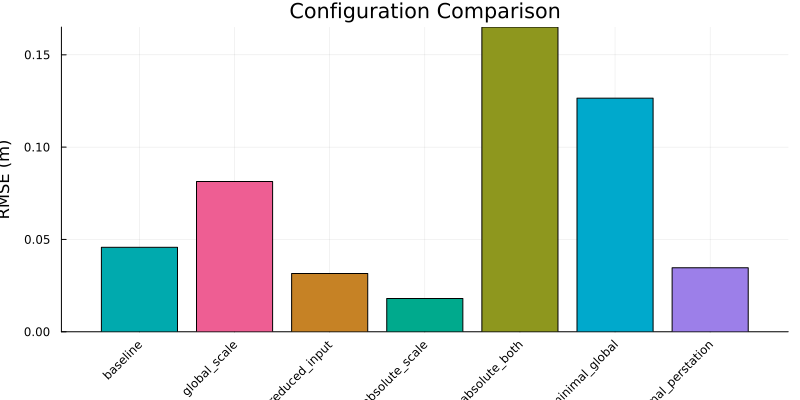

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/comparison/configuration_experiments/06_main_rmse_comparison.png"

In [ ]:
# Load all configurations
configs_to_compare = ["baseline", "global_scale", "reduced_input", "absolute_scale", "global_absolute_both", "minimal_global", "minimal_perstation"]
all_configs_data = Dict()

for cfg_name in configs_to_compare
    file = joinpath(output_dir, "result_$(cfg_name)_s$(surrogate).jld2")
    @load file result
    all_configs_data[cfg_name] = result
end

# Multi-config RMSE comparison
p_multi = bar([cfg for cfg in configs_to_compare], [all_configs_data[cfg]["rmse_corrected"] for cfg in configs_to_compare],
              ylabel="RMSE (m)", title="Configuration Comparison", legend=false, xrotation=45, size=(800, 400), color=cur_colors[6:length(configs_to_compare)+5])
display(p_multi)
savefig(p_multi, joinpath(output_dir, "06_main_rmse_comparison.png"))

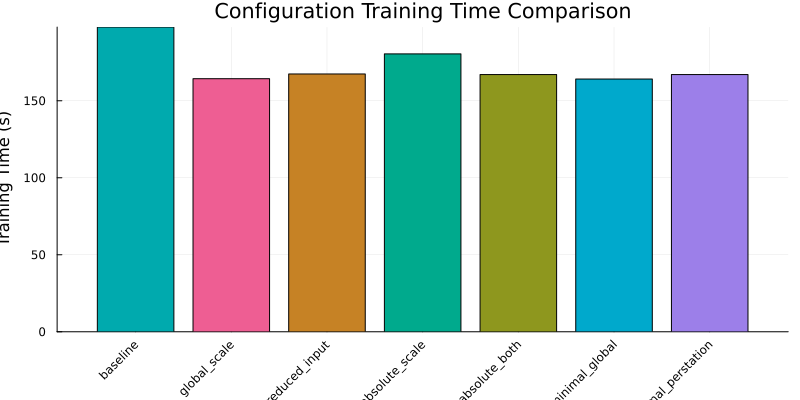

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/comparison/configuration_experiments/07_main_timing_comparison.png"

In [ ]:
## Timing Comparison 
p_time = bar([cfg for cfg in configs_to_compare], [all_configs_data[cfg]["training_time"] for cfg in configs_to_compare], ylabel="Training Time (s)", 
              title="Configuration Training Time Comparison", legend=false, xrotation=45, size=(800, 400), color=cur_colors[6:length(configs_to_compare)+5])
display(p_time)
savefig(p_time, joinpath(output_dir, "07_main_timing_comparison.png"))